## Step 1: Import Necessary Libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#install modules
#this module should be installed only the first time you run this code in Colab or when you create a new virtual environment
!pip install rasterio
#import libraries
import rasterio
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage.exposure import match_histograms
from skimage import exposure

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.5/21.5 MB 83.8 MB/s eta 0:00:00


## Step 2: Load Bands 2, 3, 4, and 8 for Pansharpening - Pre flood

In [ ]:
# Define file paths for the bands you intend to pansharpen

# Step 1: Load the Pre-Flood Panchromatic Band (Band 8)
folder_path = '/content/drive/MyDrive/Colab Notebooks/Flood Detection and Damage Assesment 2/Pansharpening/pre-flood'
pre_flood_band8_path = f'{folder_path}/pre_flood_B8_clipped.tif'

with rasterio.open(pre_flood_band8_path) as src:
    band8 = src.read(1)

#Step 2: Load bands

folder_path = '/content/drive/MyDrive/Colab Notebooks/Flood Detection and Damage Assesment 2/Pansharpening/pre-flood'
band2_path = f'{folder_path}/pre_flood_B2_clipped.tif'
band3_path = f'{folder_path}/pre_flood_B3_clipped.tif'
band4_path = f'{folder_path}/pre_flood_B4_clipped.tif'

# Load the bands using rasterio
with rasterio.open(band2_path) as src:
    band2 = src.read(1)
with rasterio.open(band3_path) as src:
    band3 = src.read(1)
with rasterio.open(band4_path) as src:
    band4 = src.read(1)


## Step 2: Load Bands 2, 3, 4 and 8 for Pansharpening - Post flood

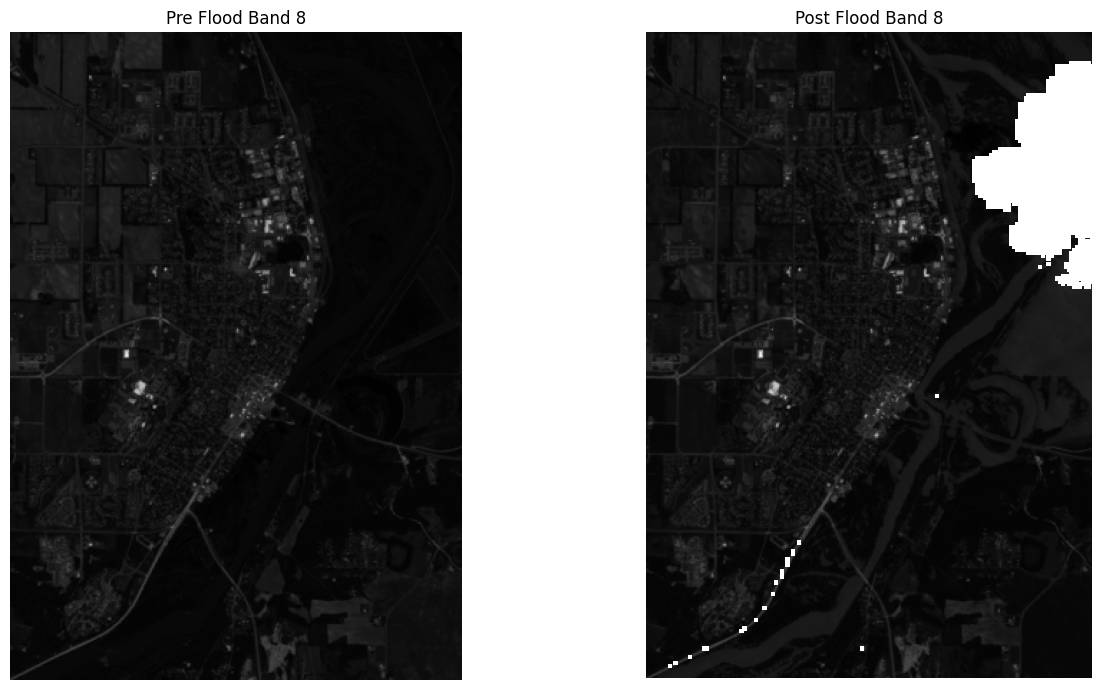

In [ ]:
#Step 1: Load the Pre-Flood Panchromatic Band (Band 8) for Histogram Matching
folder_path = '/content/drive/MyDrive/Colab Notebooks/Flood Detection and Damage Assesment 2/Pansharpening'
pre_flood_band8_path = f'{folder_path}/pre-flood/pre_flood_B8_clipped.tif'

with rasterio.open(pre_flood_band8_path) as src:
    pre_flood_band8 = src.read(1)

# Step 2: Load the Post-Flood Panchromatic Band (Band 8)
post_flood_band8_path = f'{folder_path}/post-flood/post_flood_B8_clipped_masked_nan.TIF'

with rasterio.open(post_flood_band8_path) as src:
    post_flood_band8 = src.read(1)

# Step 3: Perform Histogram Matching on the Post-Flood Panchromatic Band
#band8 = match_histograms(post_flood_band8, pre_flood_band8)
band8 = post_flood_band8

#Step 4: Plot the results after Histogram Matching
fig, axs = plt.subplots(1, 2, figsize=(14, 7))

titles = ['Pre Flood Band 8', 'Post Flood Band 8']
bands = [pre_flood_band8, band8]

for ax, band, title in zip(axs, bands, titles):
    ax.imshow(band, cmap='gray')
    ax.set_title(title)
    ax.axis('off')

# Adjust layout and show the plots
plt.tight_layout()
plt.show()

# Step 5: Plot Histograms
#fig, axs = plt.subplots(1, 3, figsize=(18, 5))

#titles = ['Pre Flood Band 8 (Reference)', 'Post Flood Band 8 (Secondary)', 'Post Flood Band 8 (Matched)']
#bands = [pre_flood_band8, post_flood_band8, band8]

#for ax, band, title in zip(axs, bands, titles):
    #ax.hist(band.ravel(), bins=256, color='blue', alpha=0.7)
    #ax.set_title(title)
    #ax.set_xlabel('Pixel Intensity')
    #ax.set_ylabel('Frequency')

# Adjust layout and show the plots
#plt.tight_layout()
#plt.show()

#Step 6: Load bands

folder_path = '/content/drive/MyDrive/Colab Notebooks/Flood Detection and Damage Assesment 2/Pansharpening'
band2_path = f'{folder_path}/post-flood/post_flood_band_2_matched.tif'
band3_path = f'{folder_path}/post-flood/post_flood_band_3_matched.tif'
band4_path = f'{folder_path}/post-flood/post_flood_band_4_matched.tif'

# Load the bands using rasterio
with rasterio.open(band2_path) as src:
    band2 = src.read(1)
with rasterio.open(band3_path) as src:
    band3 = src.read(1)
with rasterio.open(band4_path) as src:
    band4 = src.read(1)

## Step 3: Pansharpen Bands 2, 3, and 4

In [ ]:
def resample_band(band, target_shape):
    # Resample the multispectral band to match the target shape (panchromatic band shape)
    resampled_band = cv2.resize(band, (target_shape[1], target_shape[0]), interpolation=cv2.INTER_CUBIC)
    return resampled_band

def pansharpen_band(band, pan_band):
    # Ensure the multispectral band matches the resolution of the panchromatic band
    band_resampled = resample_band(band, pan_band.shape)

    # Normalize the panchromatic band to match the range of the input band (0-255)
    pan_band = cv2.normalize(pan_band, None, 0, 255, cv2.NORM_MINMAX)
    pan_band = pan_band.astype(np.uint8)  # Convert to 8-bit

    # Normalize the resampled multispectral band to 8-bit as well
    band_resampled = cv2.normalize(band_resampled, None, 0, 255, cv2.NORM_MINMAX)
    band_resampled = band_resampled.astype(np.uint8)  # Convert to 8-bit

    # Convert the grayscale band to BGR (3 channels)
    hsv_img = cv2.cvtColor(band_resampled, cv2.COLOR_GRAY2BGR)

    # Convert BGR to HSV
    hsv_img = cv2.cvtColor(hsv_img, cv2.COLOR_BGR2HSV)

    # Replace the V (intensity) channel with the panchromatic band
    hsv_img[:, :, 2] = pan_band

    # Convert back to BGR and then to grayscale
    pansharpened_band = cv2.cvtColor(hsv_img, cv2.COLOR_HSV2BGR)
    pansharpened_band = cv2.cvtColor(pansharpened_band, cv2.COLOR_BGR2GRAY)

    return pansharpened_band

# Apply pansharpening to each band (ensure the panchromatic band is high resolution)
pansharpened_band2 = pansharpen_band(band2, band8)
pansharpened_band3 = pansharpen_band(band3, band8)
pansharpened_band4 = pansharpen_band(band4, band8)




<ipython-input-6-0a5625453cee>:12: RuntimeWarning: invalid value encountered in cast
  pan_band = pan_band.astype(np.uint8)  # Convert to 8-bit
<ipython-input-6-0a5625453cee>:16: RuntimeWarning: invalid value encountered in cast
  band_resampled = band_resampled.astype(np.uint8)  # Convert to 8-bit


## Step 4: Plot the original and pansharpened band 2


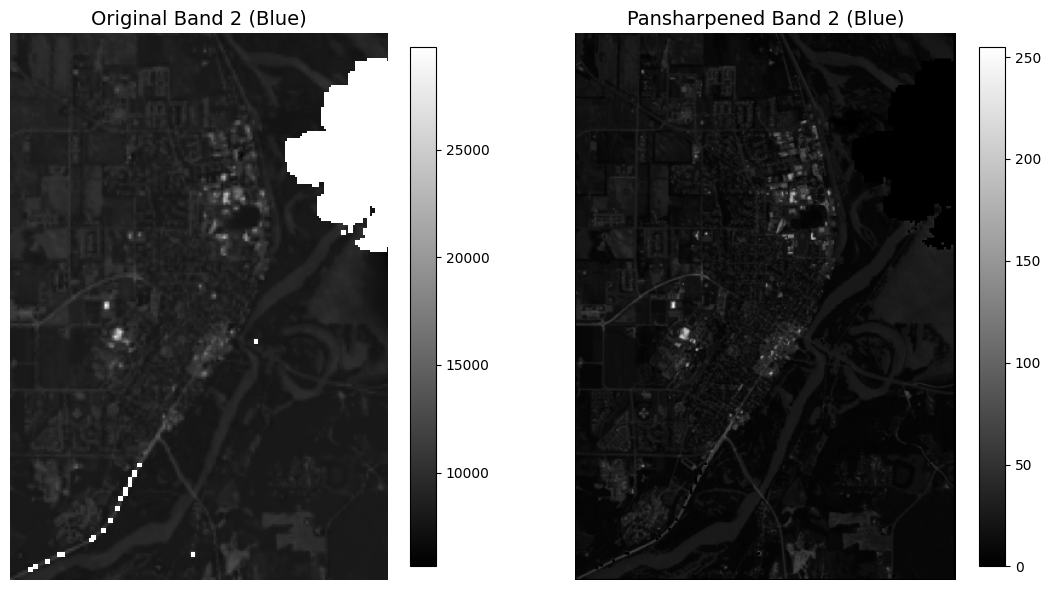

In [ ]:
# Create a 1x2 grid plot
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Function to plot a band with a colorbar
def plot_with_colorbar(ax, band, title, cmap='gray'):
    cax = ax.imshow(band, cmap=cmap)
    ax.set_title(title, fontsize=14)
    ax.axis('off')
    fig.colorbar(cax, ax=ax, fraction=0.046, pad=0.04)

# Plot Original Band 2 (Blue)
plot_with_colorbar(axs[0], band2, 'Original Band 2 (Blue)')

# Plot Pansharpened Band 2 (Blue)
plot_with_colorbar(axs[1], pansharpened_band2, 'Pansharpened Band 2 (Blue)')

# Adjust layout to improve spacing
plt.tight_layout()
plt.show()


## Step 5: Convert and save the pansharpened bands to UInt16 directly - Preflood

In [1]:
def save_as_uint16_with_correct_resolution(band, reference_band_path, output_path):
    with rasterio.open(reference_band_path) as src:
        profile = src.profile
        profile.update(dtype=rasterio.uint16, count=1)

        # Convert to UInt16 by scaling
        band_uint16 = band.astype('uint16')

        # Update the transform to reflect the new 15-meter resolution
        transform = src.transform
        new_transform = transform * transform.scale(
            src.width / band.shape[1],
            src.height / band.shape[0]
        )
        profile.update(transform=new_transform, width=band.shape[1], height=band.shape[0])

        with rasterio.open(output_path, 'w', **profile) as dst:
            dst.write(band_uint16, 1)

# Define output paths for the final UInt16 pansharpened bands
output_folder = '/content/drive/MyDrive/Colab Notebooks/Flood Detection and Damage Assesment 2/Pansharpening/pre-flood'
pansharpened_band2_final_path = f'{output_folder}/pre_flood_band2_final_uint16.tif'
pansharpened_band3_final_path = f'{output_folder}/pre_flood_band3_final_uint16.tif'
pansharpened_band4_final_path = f'{output_folder}/pre_flood_band4_final_uint16.tif'

# Save the pansharpened bands directly in UInt16 with updated resolution
save_as_uint16_with_correct_resolution(pansharpened_band2, band2_path, pansharpened_band2_final_path)
save_as_uint16_with_correct_resolution(pansharpened_band3, band3_path, pansharpened_band3_final_path)
save_as_uint16_with_correct_resolution(pansharpened_band4, band4_path, pansharpened_band4_final_path)

NameError: name 'pansharpened_band2' is not defined

## Step 5: Convert and save the pansharpened bands to UInt16 directly - Postflood

In [ ]:
import numpy as np
import rasterio

def save_as_uint16_with_correct_resolution(band, reference_band_path, output_path, nodata_value=65535):
    with rasterio.open(reference_band_path) as src:
        profile = src.profile
        profile.update(dtype=rasterio.uint16, count=1, nodata=nodata_value)  # Update nodata in profile

        # Replace nan with the nodata value
        band_uint16 = np.where(np.isnan(band), nodata_value, band).astype('uint16')

        # Update the transform to reflect the new 15-meter resolution
        transform = src.transform
        new_transform = transform * transform.scale(
            src.width / band.shape[1],
            src.height / band.shape[0]
        )
        profile.update(transform=new_transform, width=band.shape[1], height=band.shape[0])

        with rasterio.open(output_path, 'w', **profile) as dst:
            dst.write(band_uint16, 1)

# Define output paths for the final UInt16 pansharpened bands
output_folder = '/content/drive/MyDrive/Colab Notebooks/Flood Detection and Damage Assesment 2/Pansharpening'
pansharpened_band2_final_path = f'{output_folder}/post-flood/post_flood_band2_final_uint16.tif'
pansharpened_band3_final_path = f'{output_folder}/post-flood/post_flood_band3_final_uint16.tif'
pansharpened_band4_final_path = f'{output_folder}/post-flood/post_flood_band4_final_uint16.tif'

# Save the pansharpened bands directly in UInt16 with updated resolution
save_as_uint16_with_correct_resolution(pansharpened_band2, band2_path, pansharpened_band2_final_path)
save_as_uint16_with_correct_resolution(pansharpened_band3, band3_path, pansharpened_band3_final_path)
save_as_uint16_with_correct_resolution(pansharpened_band4, band4_path, pansharpened_band4_final_path)


## Step 6: Save bands as tif in Google Drive - Pre flood with 8bit data type

In [ ]:

# Define output paths
output_folder = '/content/drive/MyDrive/Colab Notebooks/Flood Detection and Damage Assessment'
pansharpened_band2_path = f'{output_folder}/pre_flood_band2_pansharpened.tif'
pansharpened_band3_path = f'{output_folder}/pre_flood_band3_pansharpened.tif'
pansharpened_band4_path = f'{output_folder}/pre_flood_band4_pansharpened.tif'

# Function to save a single band GeoTIFF
def save_geotiff(band, reference_band_path, output_path):
    with rasterio.open(reference_band_path) as src:
        profile = src.profile
        profile.update(dtype=rasterio.uint8, count=1)  # Update data type and count for single band

        with rasterio.open(output_path, 'w', **profile) as dst:
            dst.write(band, 1)

# Save the matched panchromatic band and pansharpened bands
save_geotiff(pansharpened_band2, band2_path, pansharpened_band2_path)
save_geotiff(pansharpened_band3, band3_path, pansharpened_band3_path)
save_geotiff(pansharpened_band4, band4_path, pansharpened_band4_path)

## Step 6: Save bands as tif in Google Drive - Post flood with 8bit data type

In [ ]:
# Define output paths
output_folder = '/content/drive/MyDrive/Colab Notebooks/Flood Detection and Damage Assesment 2/Pansharpening'
#matched_band8_path = f'{output_folder}/post_flood_B8_matched.tif'
pansharpened_band2_path = f'{output_folder}/post-flood/post_flood_band2_pansharpened.tif'
pansharpened_band3_path = f'{output_folder}/post-flood/post_flood_band3_pansharpened.tif'
pansharpened_band4_path = f'{output_folder}/post-flood/post_flood_band4_pansharpened.tif'

# Function to save a single band GeoTIFF
def save_geotiff(band, reference_band_path, output_path):
    with rasterio.open(reference_band_path) as src:
        profile = src.profile
        profile.update(dtype=rasterio.uint8, count=1)  # Update data type and count for single band

        with rasterio.open(output_path, 'w', **profile) as dst:
            dst.write(band, 1)

# Save the matched panchromatic band and pansharpened bands
#save_geotiff(band8, post_flood_band8_path, matched_band8_path)
save_geotiff(pansharpened_band2, band2_path, pansharpened_band2_path)
save_geotiff(pansharpened_band3, band3_path, pansharpened_band3_path)
save_geotiff(pansharpened_band4, band4_path, pansharpened_band4_path)

ValueError: Given nodata value, nan, is beyond the valid range of its data type, uint8.